<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Models" data-toc-modified-id="Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Models</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#PPM" data-toc-modified-id="PPM-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>PPM</a></span></li></ul></div>

In [1]:
# default_exp mppn

MPPN
===



This notebook includes the implementation of the `MPPN` as described in the paper. It includes the pytorch models, a training procedure containing pre-processing and data loader generation, the implementation of the `PPModel` based on MPPN's pytorch models for each process prediction task.

In [2]:
#hide

%load_ext autoreload
%autoreload 2
%load_ext memory_profiler
%load_ext line_profiler
%matplotlib inline

In [3]:
#export
from mppn.imports import *
from mppn.preprocessing import *
from mppn.pipeline import *
from mppn.baselines import *

In [4]:
_RUN_TRAINING=True

## Models

In [5]:
#export

class BaseMPPN(nn.Module):

    def __init__(self, num_perspectives, feature_size=64, output_dim=128):
        super(BaseMPPN, self).__init__()
        self.feature_size = feature_size
        self.output_dim = output_dim
        self.mode = 99
        self.stop_training = False

        if self.mode == 1:
            self.num_perspectives = 1
        else:
            self.num_perspectives = num_perspectives

        self.CNN = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4, stride=2),
            nn.Conv2d(64, 64, kernel_size=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(in_channels=64, out_channels=self.feature_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.MLP = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * self.feature_size, self.num_perspectives * self.feature_size),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * self.feature_size, self.num_perspectives * int(self.feature_size)),
            nn.ReLU(inplace=True),
            nn.Linear(self.num_perspectives * int(self.feature_size), self.output_dim),
        )

    def forward(self, x):
        x = x.transpose(0, 1)

        view_pool = []

        for v in x:
            """size of v: [batch_size, 3, img_height, img_width]"""
            """Get features from GAFs using CNN"""
            v = self.CNN(v)
            """size of v: [batch_size, feature_size, ?, ?], last two should be 1, 1"""
            """Reduce dimensions from 4 to 2 (first is batchsize)"""
            v = v.view(v.size(0), self.feature_size)


            view_pool.append(v)


        pooled_view = view_pool[0]
        """Max-pooling of all views"""
        if self.mode == 1:
            for i in range(1, len(view_pool)):
                pooled_view = torch.max(pooled_view, view_pool[i])

        else:
            """Concatenate features from all perspectives"""
            pooled_view = torch.cat(view_pool, dim=1)

        """Get representation from MLP"""
        representation = self.MLP(pooled_view)

        return representation

    def count_parameters(self):

        param_CNN = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)
        param_MLP = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)

        params = param_CNN + param_MLP

        return params

In [6]:
#export

class MPPNClassifier(BaseMPPN):
    """
    Extends Base MPPN with one classification layer.
    """

    def __init__(self, num_perspectives, num_classes, feature_size=64, output_dim=128,with_softmax=True):
        super().__init__(num_perspectives, feature_size=feature_size, output_dim=output_dim)
        self.with_softmax=num_classes!=1
        self.classification = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(output_dim, num_classes)
        )

    def forward(self, x):
        representation = BaseMPPN.forward(self, x)
        classifier_output = self.classification(representation)
        if self.with_softmax:
            classifier_output=F.log_softmax(classifier_output,dim=1)
        return classifier_output

In [7]:
#export

class MPPNMultitask(BaseMPPN):
    """
    Extends the MPPNClassifier with multiple heads to predict multiple outputs at once.
    """
    def __init__(self, num_perspectives, output_attr, feature_size=64, representation_dim=128):
        super().__init__(num_perspectives, feature_size=feature_size, output_dim=representation_dim)
        del self.MLP

        self.output_attr = output_attr
        self.representation_dim = representation_dim

        """Get the output dimension of the CNN"""
        self.CNN_out_dim = self.CNN[-3].out_channels

        self.MLP = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * self.feature_size, self.num_perspectives * int(self.feature_size/2)),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(self.num_perspectives * int(self.feature_size/2), self.representation_dim),
        )

        """Dynamically create heads for each attribute to predict"""
        self.output_attr = self.output_attr
        self.heads = nn.ModuleList()
        for attr_name, output_dim in self.output_attr.items():
            #print("Head", attr_name)
            self.heads.append(self.create_head(output_dim))


    def forward(self, x):

        x = x.transpose(0, 1)

        view_pool = []

        for v in x:
            """size of v: [batch_size, 3, img_height, img_width]"""
            """Get features from GAFs using CNN"""
            v = self.CNN(v)
            """size of v: [batch_size, feature_size, ?, ?], last two should be 1, 1"""
            """Reduce dimensions from 4 to 2 (first is batchsize)"""
            v = v.view(v.size(0), self.feature_size)

            view_pool.append(v)

        pooled_view = view_pool[0]
        """Max-pooling of all views"""
        if self.mode == 1:
            for i in range(1, len(view_pool)):
                pooled_view = torch.max(pooled_view, view_pool[i])

        else:
            """Concatenate features from all perspectives"""
            pooled_view = torch.cat(view_pool, dim=1)

        shared = self.MLP(pooled_view)

        outputs = []

        """Predict each attribute"""
        for head in self.heads:
            if head[-1].out_features > 1:
                outputs.append(F.log_softmax(head(shared), dim=1))
            else:
                outputs.append(head(shared))

        return outputs


    def create_head(self, num_classes):
        """Create a head, i.e. a subnetwork to predict a certain attribute in multi-task fashion"""
        head = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(self.representation_dim, self.representation_dim),
            nn.ReLU(inplace=True),
            nn.Linear(self.representation_dim, num_classes)
        )

        return head

    def count_parameters(self):

        param_CNN = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)
        param_MLP = sum(p.numel() for p in self.MLP.parameters() if p.requires_grad)
        param_heads = sum(p.numel() for head in self.heads for p in head.parameters() if p.requires_grad)

        params = param_CNN + param_MLP + param_heads

        return params

In [8]:
#export

def load_checkpoint(path, filename):
    """
    Load checkpoint from disk

    Parameters
    ----------
    path
    filename

    Returns
    -------

    """
    loadpath = os.path.join(path, filename + '_checkpoint.pth.tar')

    assert os.path.isfile(loadpath), 'Error: no checkpoint file found!'

    checkpoint = torch.load(loadpath)

    return checkpoint

In [9]:
#export

import torch.utils.model_zoo as model_zoo
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

def mppn_pretraining_model(pretrained=False, **kwargs):
    """Returns a model either pretrained as alexnet or on GAF images."""
    model = MPPNClassifier(**kwargs)

    pretrained_model = "alexnet"

    if pretrained:
        if pretrained_model == "alexnet":
            print("Loading Alexnet to train MPPNs CNN from scratch")
            pretrained_dict = model_zoo.load_url(model_urls['alexnet'])
            model_dict = model.state_dict()
            # 1. filter out unnecessary keys
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if
                               k in model_dict and v.shape == model_dict[k].shape}
            # 2. overwrite entries in the existing state dict
            model_dict.update(pretrained_dict)
            # 3. load the new state dict
            model.load_state_dict(model_dict)

        elif pretrained_model == "MPPN_GAF":
            print("Load pretrained MPPN trained with GAFs on variant classification")
            checkpoint = load_checkpoint(os.path.join(root_dir(), "data", "ML", "checkpoint"),
                                         filename="MPPN_gaf_pretrained")
            best_model = checkpoint["model"]
            best_model.load_state_dict(checkpoint['state_dict'])

            model.CNN = best_model.CNN

    return model

In [10]:
#export

def mppn_representation_learning_model(pretrained, num_perspectives, output_attr, feature_size=64, representation_dim=128):
    """Returns a model for representation learning (multitask). CNN is pretrained on GAF images"""
    model = MPPNMultitask(num_perspectives, output_attr, feature_size, representation_dim)

    if pretrained:
        print("Load pretrained MPPN trained with GAFs on variant classification")
        #checkpoint = load previously trained model on GAF images
        best_model = checkpoint["model"]
        best_model.load_state_dict(checkpoint['state_dict'])

        model.CNN = best_model.CNN
    else:
        alexnet_mppn = mppn_pretraining_model(pretrained=True, num_perspectives=num_perspectives, num_classes=1)
        model.CNN = alexnet_mppn.CNN

    return model

In [11]:
#export

def mppn_fine_tuning_model(representation_model, num_perspectives, num_classes):
    """
    Fine-tune a MPPN model that has been trained as representation model on a specific task

    Parameters
    ----------
    dataset: Specifies the dataset, for which the model was trained before.

    Returns
    -------
    """


    model = MPPNClassifier(num_perspectives, num_classes=num_classes)

    model.CNN = representation_model.CNN
    model.MLP = representation_model.MLP


    return model

## Training

In [12]:
#export

from pyts.image import GramianAngularField
from PIL import Image

def _gaf_loop(e,transformer):
        inp,y=e
        inp[inp>1]=1
        inp[inp<0]=0
        inp=inp*2-1
        x=torch.stack(
            tuple(_gaf_attr(inp[:,i],transformer) for i in range(inp.shape[1]))
        ).transpose(0,1)
        x=x[:,:,None].expand(-1,-1,3,-1,-1)
        return x,y

def _gaf_attr(x,transformer):
    try:

        x = transformer.transform(x)
    except ValueError as e:
        print(x)
        raise e
    x=tensor(x).cuda()
    x = x * 255
    return x



class gaf_transform(ItemTransform):
    ''' GAF transormation: converts a bash into a gramian angular field and reshapes it to RGB'''
    def __init__(self,gs=64):
        self.transformer=GramianAngularField(image_size=gs,sample_range=None, method="s", overlapping=True)

    def encodes(self,e): return _gaf_loop(e,self.transformer)

In [13]:
v=torch.rand((2556,10,100)),10
gt=gaf_transform()

In [14]:
%%time
x,y=gt(v)


CPU times: user 5.55 s, sys: 1.22 s, total: 6.78 s
Wall time: 3.71 s


In [15]:
#export
def mppn_get_output_attributes(o):
    '''Utility function that puts vocab size of each output attribute in a dict. 
    For regression tasks, it adds vocab size 1'''
    output_attributes = {i:len(o.procs.categorify[i]) for i in o.ycat_names }
    for i in o.ycont_names: output_attributes[i]=1
    return output_attributes

The next few cells show how to create a dataloader for MPPN and apply them to the representation learning and the finetuning step

In [16]:
# Create mppn repreentation learning and create the dataloader
path=EventLogs.Mobis
log=import_log(path)
_t=attr_dict[get_ds_name(path)]
cat_names,cont_names,date_names=[_t[i] for i in list(_t)]
o=PPObj(log,[Categorify,Datetify,FillMissing,MinMax],
        cat_names=cat_names,cont_names=cont_names,date_names=date_names,
        splits=split_traces(log),y_names=['activity','resource','timestamp_Relative_elapsed_minmax'])
output_attributes=mppn_get_output_attributes(o)
m = mppn_representation_learning_model(False, len(o.cont_names), output_attributes)
dls=o.get_dls(after_batch=gaf_transform,bs=64)


Loading Alexnet to train MPPNs CNN from scratch


In [17]:
# Get one batch
xb,yb=dls.one_batch()

In [18]:
# Get loss and metrics
loss=partial(multi_loss_sum,o)
metrics=get_metrics(o)


In [19]:
# Test forward pass
xb=xb.cpu()
p=m(xb)
loss(p,yb)

TensorBase(10.9851, grad_fn=<AliasBackward>)

epoch,train_loss,valid_loss,acc_activity,acc_resource,mae_days,time
0,2.806212,2.718509,0.939918,0.402286,6.824545,00:57


Better model found at epoch 0 with valid_loss value: 2.7185089588165283.


Better model found at epoch 0 with valid_loss value: 0.940420389175415.


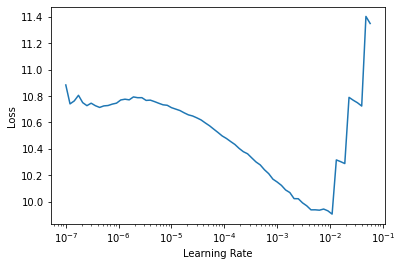

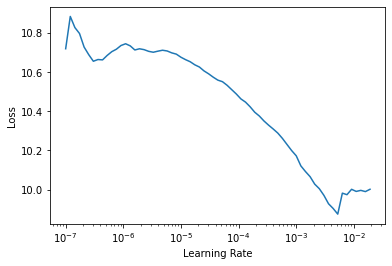

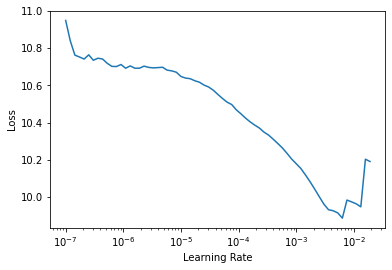

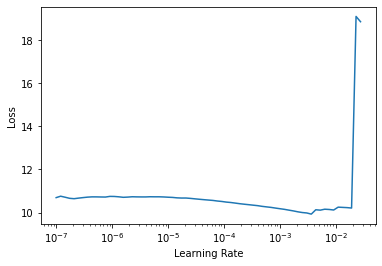

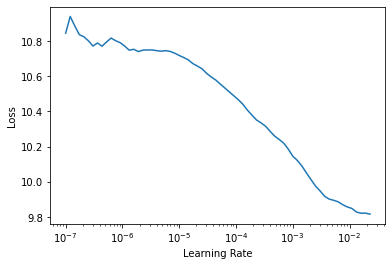

In [20]:
# Train representation learning model
if _RUN_TRAINING:
    train_validate(dls,m,loss=loss,metrics=metrics,epoch=1)

In [21]:
# Create Fine-tuning model
col='activity'
m2 = mppn_fine_tuning_model(m, len(output_attributes), output_attributes[col])

In [22]:
# Change input and output features for the dataloader
o.ycat_names=L(col)
o.ycont_names=L()

In [23]:
# get new dataloader for next-activity prediction
dls=o.get_dls(after_batch=gaf_transform,bs=60)

In [24]:
# get new loss and metrics for for next-activity prediction
loss=partial(multi_loss_sum,o)
metrics=get_metrics(o)

In [25]:
# Test forward pass

xb,yb=dls.one_batch()
yb.shape

p=m2.cuda()(xb.cuda())

accuracy(p.cuda(),yb.cuda())

TensorBase(0., device='cuda:0')

epoch,train_loss,valid_loss,acc_activity,time
0,0.201164,0.185873,0.936980,00:58
1,0.164601,0.175458,0.930531,00:53
2,0.193403,0.174247,0.940000,00:54
3,0.187607,0.199790,0.936327,00:54
4,0.203035,0.222902,0.927510,00:54


Better model found at epoch 0 with valid_loss value: 0.18587279319763184.
Better model found at epoch 1 with valid_loss value: 0.17545795440673828.
Better model found at epoch 2 with valid_loss value: 0.17424732446670532.
No improvement since epoch 1: early stopping


Better model found at epoch 0 with valid_loss value: 0.939941942691803.


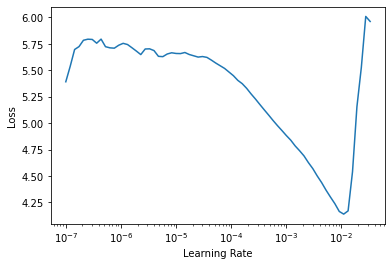

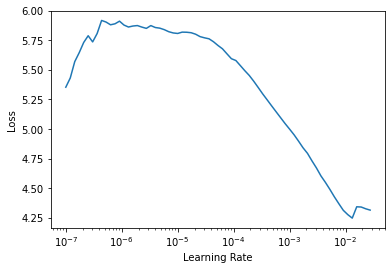

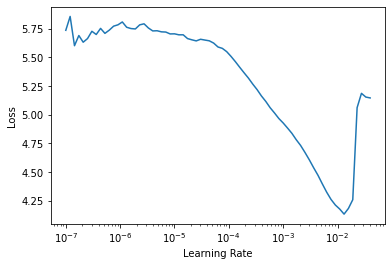

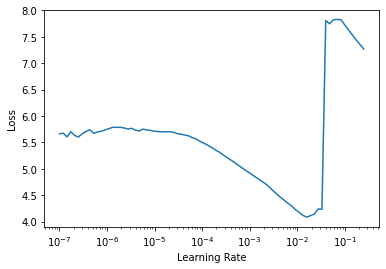

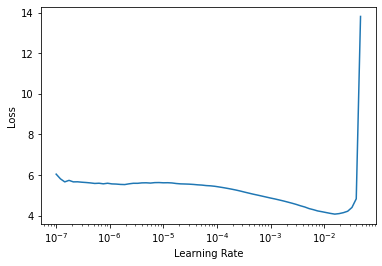

In [26]:
# Train model
if _RUN_TRAINING:
    train_validate(dls,m2,loss=loss,metrics=metrics,epoch=1)

## PPM

Creates the PPM for the MPPM. In the setup der general representation learning model is trained. Afterwards, in each prediction task, a seperate head is created, which is than fine-tuned for the specific task.

In [27]:
#export
import copy

In [28]:
#export

class PPM_MPPN(PPModel):


    def _attr_from_dict(self,ds_name):
        if not self.attr_dict: raise AttributeError('attr_dict is required!')

        return (listify(self.attr_dict[self.ds_name]['cat attr']),
                listify(self.attr_dict[self.ds_name]['num attr']),
                listify(self.attr_dict[self.ds_name]['date attr']))


    def setup(self):
        def act_acc(p,y): return accuracy(p[0],y[0])
        def act_res(p,y): return accuracy(p[1],y[1])
        cat_names,cont_names,date_names=self._attr_from_dict(self.ds_name)
        self.o=PPObj(self.log,[Categorify,Datetify,FillMissing,MinMax],
                     cat_names=cat_names,date_names=date_names,cont_names=cont_names,
                     y_names=['activity','resource','timestamp_Relative_elapsed'],
                     splits=self.splits)
        self.o.cont_names=['timestamp_Relative_elapsed']
        norm=Normalize()
        self.o.procs.add(norm,self.o)
        self.mean=norm.means['timestamp_Relative_elapsed']
        self.std=norm.stds['timestamp_Relative_elapsed']
        self.o.cont_names=L(['activity_minmax','resource_minmax','timestamp_Relative_elapsed_minmax'])
        self.output_attributes=mppn_get_output_attributes(self.o)
        self.pretrain = mppn_representation_learning_model(False, len(self.o.cont_names), self.output_attributes)
        dls=self.o.get_dls(after_batch=gaf_transform,bs=self.bs)
        loss=partial(multi_loss_sum,self.o)
        time_metric=lambda p,y: maeDurDaysNormalize(listify(p)[-1],listify(y)[-1],mean=self.mean,std=self.std)
        self._train_validate(dls,self.pretrain,loss=loss,metrics=[act_acc,act_res,time_metric])




    def next_step_prediction(self,col='activity',outcome=False):
        pretrain=copy.deepcopy(self.pretrain)
        m = mppn_fine_tuning_model(pretrain, len(self.output_attributes), self.output_attributes[col])
        self.o.ycat_names,self.o.ycont_names=L(col),L()
        dls=self.o.get_dls(after_batch=gaf_transform,bs=self.bs,outcome=outcome)
        loss=partial(multi_loss_sum,self.o)
        metrics=get_metrics(self.o)
        return self._train_validate(dls,m,loss=loss,metrics=metrics)

    def next_resource_prediction(self):return self.next_step_prediction(outcome=False,col='resource')

    def last_resource_prediction(self): return self.next_step_prediction(outcome=True,col='resource')
    def outcome_prediction(self): return self.next_step_prediction(outcome=True)

    def duration_to_next_event_prediction(self,outcome=False,col='timestamp_Relative_elapsed'):
        pretrain=copy.deepcopy(self.pretrain)
        time=partial(maeDurDaysNormalize,mean=self.mean,std=self.std)
        m = mppn_fine_tuning_model(pretrain, len(self.output_attributes), self.output_attributes[col])
        self.o.ycat_names,self.o.ycont_names=L(),L(col)
        dls=self.o.get_dls(after_batch=gaf_transform,bs=self.bs,outcome=outcome)
        xb,yb=dls.one_batch()
        return self._train_validate(dls,m,loss=mae,metrics=time)


    def duration_to_end_prediction(self):return self.duration_to_next_event_prediction(outcome=True)

In [29]:
%%time
if  _RUN_TRAINING:
    path=EventLogs.BPIC_12_O
    log=import_log(path)
    ppm=PPM_MPPN(log,get_ds_name(path),split_traces(log),print_output=True,epoch=1,bs=512,attr_dict=attr_dict)
    ppm.setup()


Loading Alexnet to train MPPNs CNN from scratch


epoch,train_loss,valid_loss,act_acc,act_res,,time
0,5.849926,5.189992,0.681125,0.071973,5.108842,00:04


Better model found at epoch 0 with valid_loss value: 5.189992427825928.


Better model found at epoch 0 with valid_loss value: 0.7095046639442444.
CPU times: user 4min 6s, sys: 9.35 s, total: 4min 15s
Wall time: 44.4 s


In [30]:
if _RUN_TRAINING: ppm.next_step_prediction()

epoch,train_loss,valid_loss,acc_activity,time
0,1.003388,0.649134,0.712583,00:04


Better model found at epoch 0 with valid_loss value: 0.6491336226463318.


Better model found at epoch 0 with valid_loss value: 0.7364696860313416.


In [31]:
if _RUN_TRAINING: ppm.duration_to_next_event_prediction()

epoch,train_loss,valid_loss,maeDurDaysNormalize,time
0,0.488340,0.379671,3.703171,00:04


Better model found at epoch 0 with valid_loss value: 0.37967097759246826.


Better model found at epoch 0 with valid_loss value: 3.591909646987915.


In [32]:
if _RUN_TRAINING: ppm.duration_to_end_prediction()

epoch,train_loss,valid_loss,maeDurDaysNormalize,time
0,0.952126,0.987435,9.631075,00:04


Better model found at epoch 0 with valid_loss value: 0.9874348044395447.


Better model found at epoch 0 with valid_loss value: 8.892857551574707.
